In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%%capture
! pip install git+https://github.com/huggingface/huggingface_hub.git@main
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [ ]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import cv2
import imghdr

## Loading the dataset
As this is a Binary Classification Task, the data consists of images with two labels: One which contains Pepe the Frog (positive sample) and the ones which don't (negative sample). The dataset provided only had positive samples, I generated the negative dataset myself, taking examples from the web. It consists of a mixture of different types of images, many of them frog-themed and others random

In [ ]:
data_dir = "/content/drive/MyDrive/pepe_dataset"

## Filtering
First, we clean our dataset by filtering out broken samples (i.e. unreadable samples or samples having wrong extensions)

In [ ]:
image_exts = ["jpeg", "jpg", "webp", "png"]

In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print("Image doesn't exist in list {}".format(image_path))
        os.remove(image_path)
    except Exception as e:
      print("Issue with image {}".format(image_path))

Image doesn't exist in list /content/drive/MyDrive/pepe_dataset/notPepe/vector-cute-frog-cartoon-style-260nw-2299043231.jpg
Image doesn't exist in list /content/drive/MyDrive/pepe_dataset/notPepe/WORLD-FROG-DAY--1200x834.jpg
Image doesn't exist in list /content/drive/MyDrive/pepe_dataset/notPepe/red-eyed-tree-frogs-on-600nw-2113089425.jpg
Image doesn't exist in list /content/drive/MyDrive/pepe_dataset/notPepe/natterjack-toad-Europe.jpg
Image doesn't exist in list /content/drive/MyDrive/pepe_dataset/notPepe/800px-European_Common_Frog_Rana_temporaria.jpg
Image doesn't exist in list /content/drive/MyDrive/pepe_dataset/notPepe/Bullfrog.jpg
Image doesn't exist in list /content/drive/MyDrive/pepe_dataset/notPepe/arrow-poison-frogs-sound-production-colour-warning-signal.jpg
Image doesn't exist in list /content/drive/MyDrive/pepe_dataset/notPepe/Green-frog.jpg
Image doesn't exist in list /content/drive/MyDrive/pepe_dataset/notPepe/Black-eyed-tree-frog.jpg
Image doesn't exist in list /content/d

In [ ]:
data = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/pepe_dataset")

Found 675 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()
data_iterator

In [ ]:
batch = data_iterator.next()
print(batch[0].shape)
batch[1].shape

(32, 256, 256, 3)


(32,)

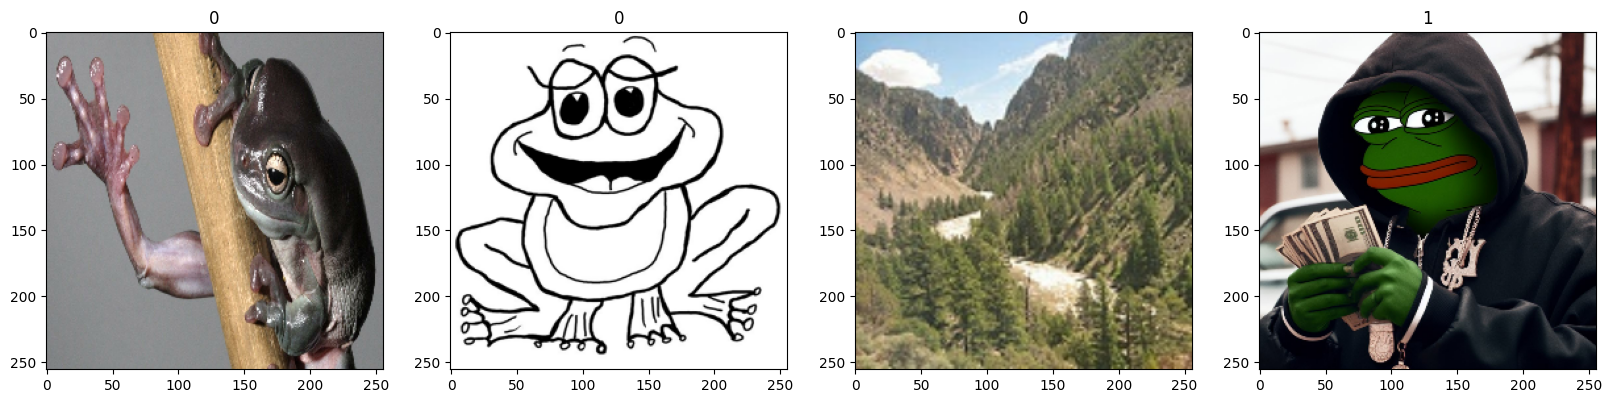

In [ ]:
# Class 0 = Not Pepe
# Class 1 = Pepe

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

## Preprocessing
The data is preprocessed by scaling down each image. This is done for optimization purposes

In [ ]:
# Creation of a data pipeline
data = data.map(lambda x,y: (x/255, y)) # x is images, y labels

AttributeError: '_MapDataset' object has no attribute 'shape'

In [ ]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [ ]:
batch[1].shape

(32,)

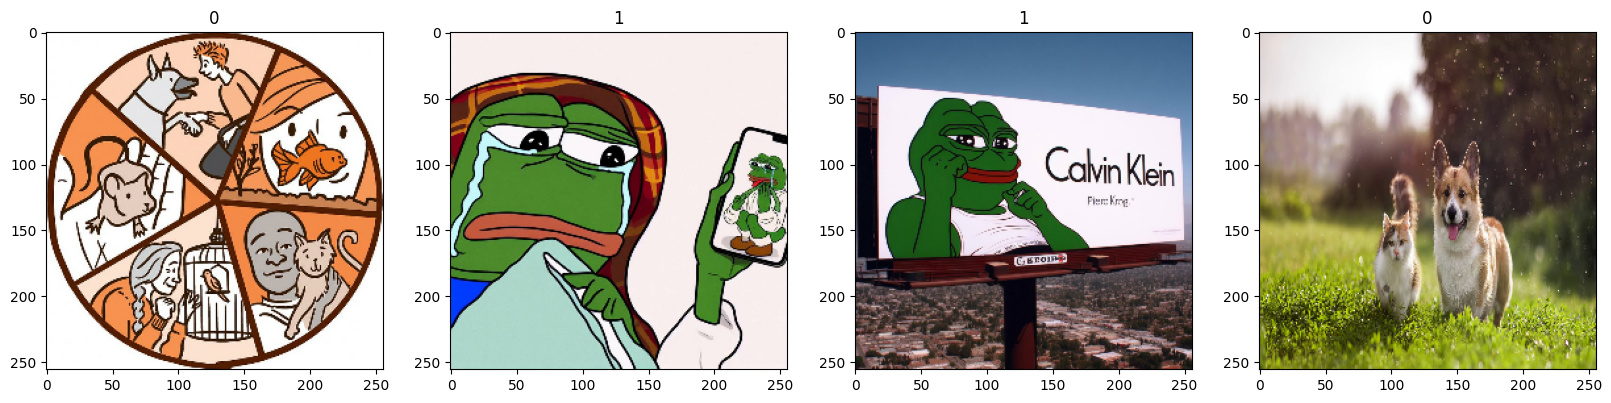

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

print(train_size)
print(val_size)
print(test_size)

15
5
2


In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

print(test_size)

2


## Model Architecture

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

## Train

In [ ]:
logdir = "/content/drive/MyDrive/Colab Notebooks/logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
15/15 [==============================] - 26s 1s/step - loss: 0.9995 - accuracy: 0.6833 - val_loss: 0.3424 - val_accuracy: 0.8500
Epoch 2/20
15/15 [==============================] - 21s 1s/step - loss: 0.3730 - accuracy: 0.8500 - val_loss: 0.3760 - val_accuracy: 0.8687
Epoch 3/20
15/15 [==============================] - 20s 1s/step - loss: 0.3078 - accuracy: 0.8729 - val_loss: 0.2444 - val_accuracy: 0.9438
Epoch 4/20
15/15 [==============================] - 19s 1s/step - loss: 0.1922 - accuracy: 0.9333 - val_loss: 0.2431 - val_accuracy: 0.9312
Epoch 5/20
15/15 [==============================] - 20s 1s/step - loss: 0.1759 - accuracy: 0.9271 - val_loss: 0.1738 - val_accuracy: 0.9438
Epoch 6/20
15/15 [==============================] - 19s 1s/step - loss: 0.1495 - accuracy: 0.9542 - val_loss: 0.1444 - val_accuracy: 0.9438
Epoch 7/20
15/15 [==============================] - 20s 1s/step - loss: 0.0905 - accuracy: 0.9729 - val_loss: 0.0829 - val_accuracy: 0.9750
Epoch 8/20
15/15 [==

## Plot

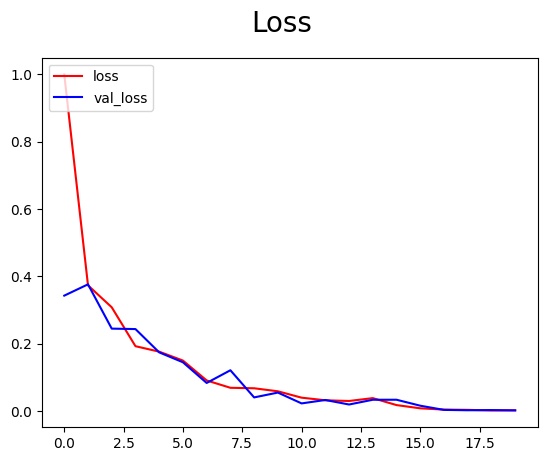

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

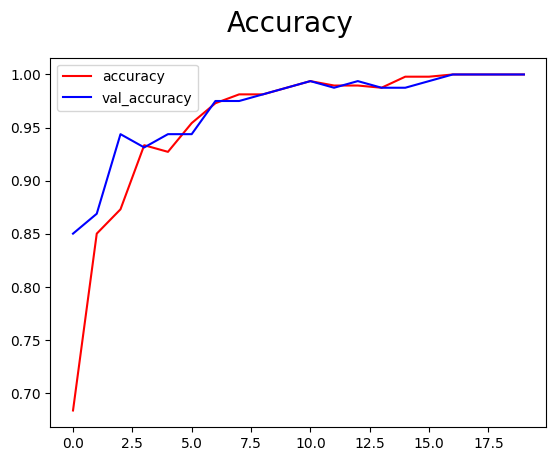

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='red', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluation

In [ ]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# test[0].shape

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 306ms/step


In [ ]:
print(f"Precision is: {pre.result().numpy()} Recall is: {re.result().numpy()} Accuracy is: {acc.result().numpy()} ")

Precision is: 1.0 Recall is: 1.0 Accuracy is: 1.0 


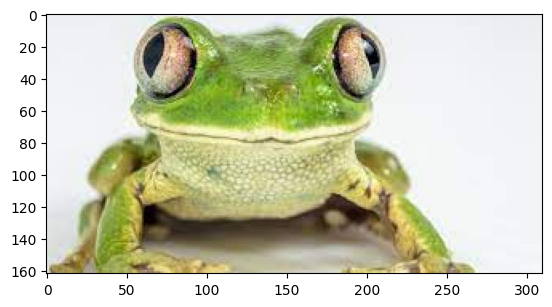

In [ ]:
img = cv2.imread('/content/drive/MyDrive/pepe_my_test/smallfrog.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

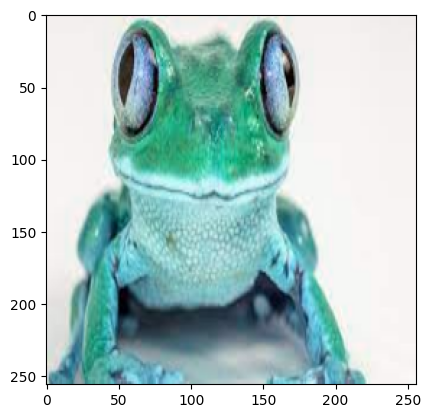

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.5:
    print(f'Predicted class contains Pepe the Frog')
else:
    print(f'Predicted class does not contain Pepe the Frog')

1/1 [==============================] - 0s 18ms/step
Predicted class does not contain Pepe the Frog


In [ ]:
from keras.models import load_model

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/models','pepeImageclassifier.keras'))

In [ ]:
new_model = load_model('/content/drive/MyDrive/models/pepeImageclassifier.keras')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 95ms/step
Predicted class does not contain Pepe the Frog


In [ ]:
from huggingface_hub import push_to_hub_keras
push_to_hub_keras(new_model, 'pepeImageClassifier')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/115k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Aaryan-Poria/pepeImageClassifier/commit/c7505ecf8caa73a186047dc8c0dbaa7eed39e46d', commit_message='Push Keras model using huggingface_hub.', commit_description='', oid='c7505ecf8caa73a186047dc8c0dbaa7eed39e46d', pr_url=None, pr_revision=None, pr_num=None)

Accuracy: 0.62708336
